# Intro to TF 101

## What is Tensorflow?


 > TensorFlow is an open-source machine learning framework used in data science and artificial intelligence. It represents data as tensors and operates on them through a computational graph. It's popular for deep learning, offering high-level APIs for neural networks. TensorFlow is flexible, scalable, and has a supportive community, making it a vital tool for master's students in machine learning and data science.

 _Cit: ChatGPT_

## What actually is Tensorflow?

It can be your best friend or your worst nightmare, depending on which background you have, and what platform you're using (but we luckly have Colab <3)

Tensorflow (from now on TF) is "mainly" a Numpy+"differentiation library" (it actually can do [muuuuch more than that](https://www.tensorflow.org/resources/libraries-extensions) but we don't care about it for the moment)... it has a little sister called Keras, which is nothing more that a set of tools that (hopefully) work out-of-the-box for DeepLearning

However, don't think that TF/Keras are just for DeepLearning... TF is used for any kind of (gradient) optimization, as we will see

## How to use it

Well, the first thing to do, it's definitely to check if Colab set this notebook to run on GPU, or tomorrow we might still be here waiting...

### Intro

Well importing it might be a nice starting step (and recall to rename it, a must, same for his little brother numpy)

In [1]:
import tensorflow as tf
import numpy as np

TF has many functionalities, that you can find in [the documentation](https://www.tensorflow.org/api_docs/python/tf), functionalities that encodes some sort of computations (data manipulation, activation functions, tensor manipulation and so on)

![](https://pbs.twimg.com/media/E10ffa9X0AA4H2_.png)

### Tensors


However, everything requires some sort of tensors (n-dimensional arrays), and there are a handful of versions that you might want to keep in mind.

In [2]:
# Constants, aka you can't change their value
# They can be scalars
your_constant = tf.constant(10)
# Or arrays
your_constant = tf.constant([10, 11])

In [3]:
# Tensors, which you can instead manipulate
your_tensor = tf.convert_to_tensor([10, 11])

However, both of them have a very specific requirements, which is that whatever is inside, has to share the same type, and the whole framework is type-checked, so a int-tensor cannot be multiplied by a float tensor.

**PSA:** TF will try to deduce the type from whatever you are passing, so be very careful

In [4]:
tf.constant(10) * tf.constant(11.)

InvalidArgumentError: ignored

In [5]:
tf.constant(10.) * tf.constant(11.)

<tf.Tensor: shape=(), dtype=float32, numpy=110.0>

You can enforce the type you want by using the `dtype` argument (present in almost all the functions of TF)

In [6]:
tf.constant(10, dtype=tf.float32) * tf.constant(11.)

<tf.Tensor: shape=(), dtype=float32, numpy=110.0>

or, you can cast it using `tf.cast`

In [7]:
tf.cast(tf.constant(10), dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

(everything is valid also for the tensors)

**PSA:** TF is very numpy friendly (they can go back and forth from np arrays to TF arrays), however, there is a very inconvenient scenario in both directions:  
 1. TF to np: you loose the gradient information (from the conversion on, tf will not register any operation and thus the gradient, we will see later what this means)
 2. np to TF: the casts tend to be using `float64`, where everything related to Deep Learning works in `float32` (yes, they are 2 different types)

In [8]:
tf.convert_to_tensor(np.array(10.))

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

Finally, if you add some computer science boilerplate wrapper around the `Tensor` class, you get the `Variable` class, which makes the TF life a bit easier in some cases (graph computation, will see it later)

![](https://i.redd.it/gpp8gmh0on861.jpg)

### Functions

TF provides a ton of functionalities, and it's useless list here all possible ones, however feel free to use ChatGPT if you need to find a function that does a certain computation, in my experience it knows TF pretty well when dealing with limited situations (don't ask to code everything in one go for you, it won't work most likely)

Heres the most useful ones:  
 1. `tf.nn` contains everything you can think that might be useful for neural networks
 2. `tf.keras` contains the Keras API
 3. `tf.optimizers` gradient optimizers
 4. `tf.random` everything dealing with randomness and sampling
 5. `tf.math` everything dealing with math functions

### Gradient

Gradients are a big part of Tensorflow, as it was born as an _automatic differentiation_ framework (God thanks for the chain-rule)

You can pretty much do anything gradient-related with `tf.GradientTape` (there are other ways, but personally I find this one the most elastic and clear one)

You can think `tf.GradientTape` as the BigBrother watching everything is happening under him (TF doesn't like privacy), and registering every step: if all such steps are performed with differentiable TF operations, he will apply the chain rule few millions times and hand you the gradient

In [9]:
# 1 - you create a variable:
v = tf.Variable(0.)

def f(x):
  return 2 * x
# 2 - you create the BigBrother
with tf.GradientTape() as tape:
  # 3 - you let the BigBrother spy on you
  y = f(v)

# 4 - you use the fruits of your privacy violation
tape.gradient(y, v) # dy / dv = df(x) / dx

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

However, TF always had the advantage over other frameworks to handle graph execution (they are catching up) over eager execution, heres a quick intro:
 1. eager execution: the one you always knew, it goes line by line and executes stuff on the fly
 2. graph execution: TF first checkes the operation graph of a function, sees if it can optimize it, and if so, simplifies/parallelize it (you have little power over what happens behind the scenes, but most of the times works just fine)  


 The whole point is that if in that function everything that happens is deterministing and never changes, it can create shorcuts (just like a compiler would do with your code), and make it faster for your GPU

In [10]:
# the @ notation is for _decorators_ in python (for the sake of the tutorial, you can consider it black magic)
@tf.function
def much_faster_function(v):
  return 2*v

v = tf.Variable(0.)
with tf.GradientTape() as tape:
  res = much_faster_function(v)

tape.gradient(res, v)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

## Let's start doing interesting stuff

If you got everything to this point, you are pretty much able to code anything in the DeepLearning community, well done

![](https://media.tenor.com/JHZWHc6hZgoAAAAC/thumbs-up-kid.gif)

As for all respected optimization tutorials, why not starting from our favourite model implementing it together...

linear regression :-)

### Simplified 101 linear regression - aka estimate the average

Since I wanted to give you a simple example of what the whole code should look like, and i couldn't come up with a nice example, heres the code to calculate the average of a bunch of points, by minimizing the mean squared error:
$$
L(\theta) = \frac{1}{N}\sum_{i=0}^N (i - mean)^2
$$

In [11]:
# defining variables
# in our case, we only need one varaible, that will represent the mean, and we will call it _average_
average = tf.Variable(0.)

# generaeting data
# we just generate some data, not really important for the sake of the example
data = tf.random.normal(shape=(100,), mean=10.)

# Optimizer (aka, please take the gradient and do a step in the opposite direction)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-1)

for i in range(100):
  with tf.GradientTape() as tape:
    # we can use tf.reduce_mean to take a N-dimensional tensor and get the average of it
    loss = tf.reduce_mean((data - average)**2)

  gradient = tape.gradient(loss, average) # this calculates the gradient dL / daverage
  optimizer.apply_gradients(zip([gradient], [average])) # applies the gradient, aka, does a step of gradient descent

  if i%10 == 0:
    print(f"average is {average.numpy()}, loss is {loss.numpy()}")

print(f"estimated average is {average.numpy()} but actual average is {tf.reduce_mean(data).numpy()}")

average is 0.09999998658895493, loss is 99.99479675292969
average is 1.0953538417816162, loss is 81.15174102783203
average is 2.069077968597412, loss is 64.60989379882812
average is 3.0040531158447266, loss is 50.498233795166016
average is 3.887022018432617, loss is 38.775325775146484
average is 4.708946704864502, loss is 29.270278930664062
average is 5.464271068572998, loss is 21.736772537231445
average is 6.150026798248291, loss is 15.896893501281738
average is 6.765193462371826, loss is 11.470059394836426
average is 7.310318470001221, loss is 8.190661430358887
estimated average is 7.742588043212891 but actual average is 9.953001022338867


As you can see, the loss goes down, and the mean moves towards the actual mean

Are optimizers just black magic? NO, they are just wrappers to very non-readable mathematical gibberish that applies the gradient to your varaibles, keeping track of extra informations (for adaptive settings or momentum)

We can definitely live without them if we prefer:

In [12]:
# defining variables
# in our case, we only need one varaible, that will represent the mean, and we will call it _average_
average = tf.Variable(0.)

for i in range(100):
  with tf.GradientTape() as tape:
    # we can use tf.reduce_mean to take a N-dimensional tensor and get the average of it
    loss = tf.reduce_mean((data - average)**2)

  gradient = tape.gradient(loss, average) # this calculates the gradient dL / daverage
  average.assign(average - 0.01 * gradient) # w = w - alpha * gradient

  if i%10 == 0:
    print(f"average is {average.numpy()}, loss is {loss.numpy()}")

print(f"estimated average is {average.numpy()} but actual average is {tf.reduce_mean(data).numpy()}")

average is 0.19906003773212433, loss is 99.99479675292969
average is 1.983321189880371, loss is 67.0672836303711
average is 3.441192388534546, loss is 45.08462905883789
average is 4.632379055023193, loss is 30.408836364746094
average is 5.605666160583496, loss is 20.61115074157715
average is 6.400911808013916, loss is 14.070141792297363
average is 7.050685405731201, loss is 9.703311920166016
average is 7.581597805023193, loss is 6.787983417510986
average is 8.01539134979248, loss is 4.841685771942139
average is 8.369832038879395, loss is 3.5423245429992676
estimated average is 8.633037567138672 but actual average is 9.953001022338867


### Your turn, time for linear regression

Well, first, maybe it's better to create a dataset... since we don't like naive stuff, let's say that we can create a synthetic dataset where:
$$
x \sim U(0.5, 5.0),\,\,\, \text{(say 100 samples)}\\
y = log(x) + \epsilon, \,\,\, \epsilon \sim N(0, 0.05)\\
L(\theta) = \sum_{x,y}\left[(wx+b) - y\right]^2
$$

In [13]:
x = tf.random.uniform(shape=(100,), minval=0.5, maxval=5.0)
y = tf.math.log(x) + tf.random.normal(shape=(100,), mean=0, stddev=0.05)

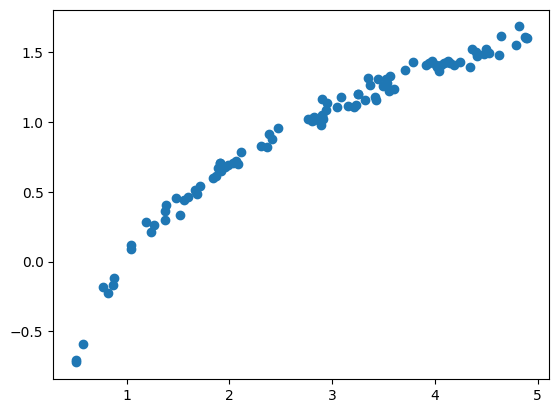

In [14]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

Looks good to me, now let's try to fit a linear model on it with TF:
$$
y = wx+b
$$

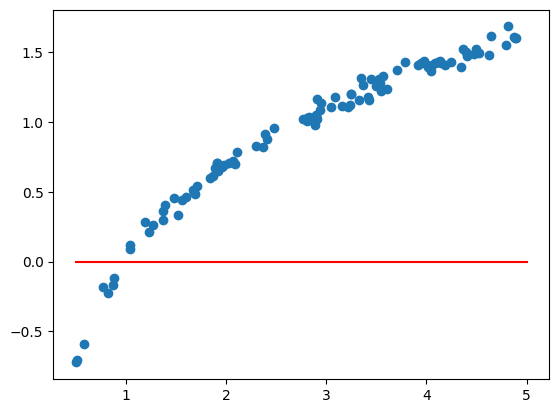

In [22]:
# well, we have one covariate, so we need only one variable
w = tf.Variable(0.)
# and our little friend bias
b = tf.Variable(0.)
# and we will need an optimizer
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def predict(x):
  return w*x+b

plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")

In [23]:
def loss(predictions, targets):
  return tf.reduce_mean((predictions - targets)**2)

for i in range(200):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 1.1776854991912842
epoch 10 - loss: 0.4984738230705261
epoch 20 - loss: 0.16155767440795898
epoch 30 - loss: 0.07196523994207382
epoch 40 - loss: 0.07256030291318893
epoch 50 - loss: 0.07163871079683304
epoch 60 - loss: 0.06430771946907043
epoch 70 - loss: 0.06033806502819061
epoch 80 - loss: 0.05806364119052887
epoch 90 - loss: 0.05549352243542671
epoch 100 - loss: 0.05298520624637604
epoch 110 - loss: 0.050650354474782944
epoch 120 - loss: 0.048394106328487396
epoch 130 - loss: 0.04624083638191223
epoch 140 - loss: 0.04420552775263786
epoch 150 - loss: 0.04228953272104263
epoch 160 - loss: 0.04049796983599663
epoch 170 - loss: 0.03883252665400505
epoch 180 - loss: 0.03729267418384552
epoch 190 - loss: 0.03587646782398224


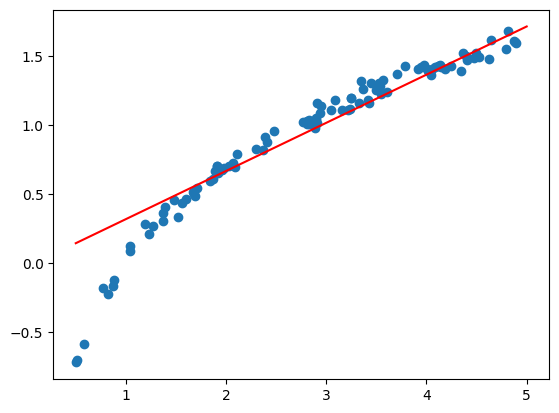

In [24]:
plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")

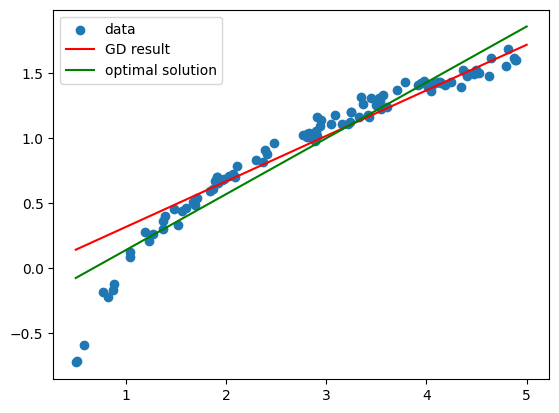

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x[..., None], y)
plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")
plt.plot([0.5, 5.0], [reg.predict([[0.5]]), reg.predict([[5.0]])], c="green")
plt.legend(["data", "GD result", "optimal solution"])

However, you are engineers, and you would do some more analysis on the model and see that the residuals are kinda bad, and so you would try to alter the data to improve it, right?

Text(0, 0.5, 'residual')

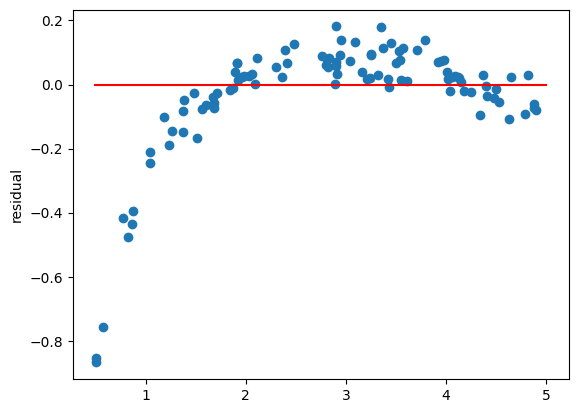

In [27]:
plt.scatter(x, y-predict(x))
plt.plot([0.5, 5.0], [0,0], c="red")
plt.ylabel("residual")

well, that's easy in our model, since we only need to redefine how to predict the target

In [32]:
w = tf.Variable(0.)
b = tf.Variable(0.)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.reduce_mean((predictions - targets)**2)

def predict(x): # !!! change here, we apply a non linear transformation to our data
  return w*tf.math.log(x)+b

for i in range(400):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 1.1776854991912842
epoch 10 - loss: 0.7988864779472351
epoch 20 - loss: 0.5105790495872498
epoch 30 - loss: 0.3110676109790802
epoch 40 - loss: 0.18724706768989563
epoch 50 - loss: 0.11914541572332382
epoch 60 - loss: 0.08607948571443558
epoch 70 - loss: 0.07147384434938431
epoch 80 - loss: 0.0647570863366127
epoch 90 - loss: 0.06060725823044777
epoch 100 - loss: 0.057003334164619446
epoch 110 - loss: 0.0534503273665905
epoch 120 - loss: 0.04993544518947601
epoch 130 - loss: 0.046512898057699203
epoch 140 - loss: 0.0432119183242321
epoch 150 - loss: 0.040043819695711136
epoch 160 - loss: 0.03701584041118622
epoch 170 - loss: 0.03413472697138786
epoch 180 - loss: 0.031406108289957047
epoch 190 - loss: 0.028833378106355667
epoch 200 - loss: 0.026417840272188187
epoch 210 - loss: 0.024158982560038567
epoch 220 - loss: 0.02205474302172661
epoch 230 - loss: 0.020101819187402725
epoch 240 - loss: 0.018295805901288986
epoch 250 - loss: 0.01663145236670971
epoch 260 - loss: 0.0

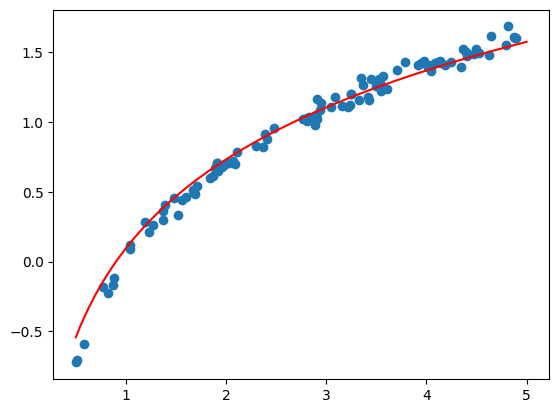

In [33]:
plt.scatter(x, y)
points = np.linspace(0.5, 5.0, 100)
plt.plot(points, predict(tf.cast(points, tf.float32)), c="red")

Say we want to use mean absolute error as loss and not mean squared error, we just need to change it in the code, and TF will handle the rest

In [35]:
w = tf.Variable(0.)
b = tf.Variable(0.)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.reduce_mean(tf.abs(predictions - targets))

def predict(x):
  return w*tf.math.log(x)+b

for i in range(400):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 0.9941486120223999
epoch 10 - loss: 0.809994101524353
epoch 20 - loss: 0.6306493878364563
epoch 30 - loss: 0.4633978307247162
epoch 40 - loss: 0.324756383895874
epoch 50 - loss: 0.23114563524723053
epoch 60 - loss: 0.19094550609588623
epoch 70 - loss: 0.18457575142383575
epoch 80 - loss: 0.17298226058483124
epoch 90 - loss: 0.1600232720375061
epoch 100 - loss: 0.14813975989818573
epoch 110 - loss: 0.13562092185020447
epoch 120 - loss: 0.12253675609827042
epoch 130 - loss: 0.10894270241260529
epoch 140 - loss: 0.09528595209121704
epoch 150 - loss: 0.08147189766168594
epoch 160 - loss: 0.06757251918315887
epoch 170 - loss: 0.05482173338532448
epoch 180 - loss: 0.04513327032327652
epoch 190 - loss: 0.039494212716817856
epoch 200 - loss: 0.036650195717811584
epoch 210 - loss: 0.03475179895758629
epoch 220 - loss: 0.03425325080752373
epoch 230 - loss: 0.03419020026922226
epoch 240 - loss: 0.03420647978782654
epoch 250 - loss: 0.034194447100162506
epoch 260 - loss: 0.03418964

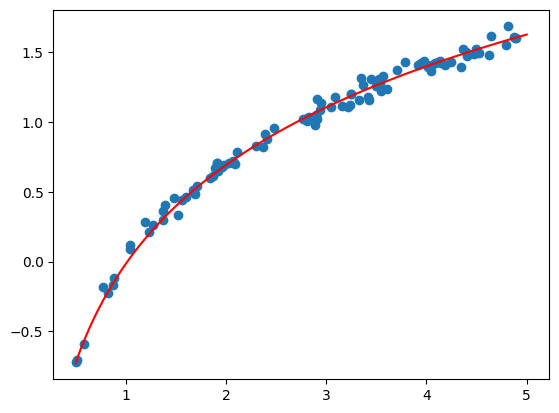

In [36]:
plt.scatter(x, y)
points = np.linspace(0.5, 5.0, 100)
plt.plot(points, predict(tf.cast(points, tf.float32)), c="red")

![](https://media.tenor.com/J5A9wZzn3ZYAAAAC/robert-redford-jeremiah-johnson.gif)

### Even PCA?

Well, we won't really implement PCA, that has some constraint on the definition of the matrixes, but at the end of the day, is purely a linear transformation of the data, and it has been proven that any linear transformation of it will lead to the same solution or to an equivalent one (same loss)

so, what we need is to minimize the following:
$$
L(\theta) = \sum_x (W^T(Wx) - x)^2
$$
Thus, we first project $x$ to a lower dimensional space via $W$, and via $W^$ we project it back to the original one, and we hope that such projection-back reconstruct $x$ as good as possible (for simplicity, we assume that the mean is 0, so we don't need the bias, but it's trivially fixable, feel free to try)

In [37]:
data = tf.random.normal(shape=(100,10), mean=0., stddev=5.0)
W = tf.Variable(tf.random.normal(shape=(10,2), mean=0., stddev=0.1))
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.reduce_mean((predictions - targets)**2)

def predict(x):
  return (x@W)@tf.transpose(W)

for i in range(1000):
  with tf.GradientTape() as tape:
    l = loss(predict(data), data)

  grad = tape.gradient(l, [W])
  optimizer.apply_gradients(zip(grad, [W]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 22.128297805786133
epoch 10 - loss: 19.845430374145508
epoch 20 - loss: 17.73483657836914
epoch 30 - loss: 17.1668758392334
epoch 40 - loss: 16.994455337524414
epoch 50 - loss: 16.762401580810547
epoch 60 - loss: 16.63686180114746
epoch 70 - loss: 16.53135108947754
epoch 80 - loss: 16.464664459228516
epoch 90 - loss: 16.409835815429688
epoch 100 - loss: 16.36768913269043
epoch 110 - loss: 16.335073471069336
epoch 120 - loss: 16.30954933166504
epoch 130 - loss: 16.290063858032227
epoch 140 - loss: 16.275487899780273
epoch 150 - loss: 16.264732360839844
epoch 160 - loss: 16.256912231445312
epoch 170 - loss: 16.251270294189453
epoch 180 - loss: 16.24721908569336
epoch 190 - loss: 16.24431037902832
epoch 200 - loss: 16.242210388183594
epoch 210 - loss: 16.240686416625977
epoch 220 - loss: 16.239564895629883
epoch 230 - loss: 16.23872947692871
epoch 240 - loss: 16.238101959228516
epoch 250 - loss: 16.237619400024414
epoch 260 - loss: 16.23724937438965
epoch 270 - loss: 16.23

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
res = pca.fit_transform(data)
rec = pca.inverse_transform(res)
print(f"MSE closed form: {((data.numpy() - rec)**2).mean()} - MSE gradient solution: {((predict(data) - data).numpy()**2).mean()}")

MSE closed form: 16.061332658250443 - MSE gradient solution: 16.235946655273438


## Let's go hardcore, neural network time

Ever coded a neural network from scratch? Well, for those who said not, it's time to finally do it right?

For the data, say we will have 6 dimensions, some will be used, some won't

In [39]:
data = tf.random.normal((1000, 6))
# the target is unreadable on purpose, I'm just applying random non linear transformation to the data, plus some noise
targets = tf.sqrt(tf.abs(
              (data[:, 0] * 10)**2 +
              tf.exp(data[:, 1]) -
               (data[:, 3] + data[:, 5]) /
              tf.abs(data[:, 4]))
) + tf.random.normal((1000,))

Now, let's recall that a fully connected layer is composed by the following:
$$
x \in R^n\\
W \in R^{n\times m}\\
b \in R^m\\
\\
output = \sigma(Wx + b)\\
$$

Well, doesn't seem too different from what we have done so far right? Then let's go on implementing it (the index in the variable refers to each layer)

In [40]:
DIMS = 1000 # middle layer dimension
initializer = tf.initializers.RandomNormal(seed=0)
# from 6 to DIMS
W1 = tf.Variable(initial_value=initializer((data.shape[1], DIMS)))
b1 = tf.Variable(initial_value=initializer((DIMS,)))
# from DIMS to 1
W2 = tf.Variable(initial_value=initializer((DIMS, 1)))
b2 = tf.Variable(initial_value=initializer((1,)))

In [41]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-3)

def loss(predictions, targets):
  return tf.reduce_mean(tf.square(predictions - targets[..., None])) # !!!!!! the [..., None]  is necessary to match the shapes, what it does is add a new dimension to the array: (N,M) => (N,M,1)

non_linearity = tf.nn.tanh

def predict(x):
  x = non_linearity(x@W1 + b1) # the @ operator is just an alias for matrix multiplication
  return x@W2 + b2


for i in range(1000):
  with tf.GradientTape() as tape:
    l = loss(predict(data), targets)

  grad = tape.gradient(l, [W1,b1,W2,b2])
  optimizer.apply_gradients(zip(grad, [W1,b1,W2,b2]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 82.09026336669922
epoch 10 - loss: 71.14878845214844
epoch 20 - loss: 59.73876190185547
epoch 30 - loss: 49.255859375
epoch 40 - loss: 42.43103790283203
epoch 50 - loss: 40.35431671142578
epoch 60 - loss: 40.51765441894531
epoch 70 - loss: 40.42459487915039
epoch 80 - loss: 40.269073486328125
epoch 90 - loss: 40.244205474853516
epoch 100 - loss: 40.21500778198242
epoch 110 - loss: 40.175968170166016
epoch 120 - loss: 40.1378173828125
epoch 130 - loss: 40.09336853027344
epoch 140 - loss: 40.0418586730957
epoch 150 - loss: 39.982723236083984
epoch 160 - loss: 39.9149055480957
epoch 170 - loss: 39.83818817138672
epoch 180 - loss: 39.75276565551758
epoch 190 - loss: 39.6594123840332
epoch 200 - loss: 39.55946350097656
epoch 210 - loss: 39.454689025878906
epoch 220 - loss: 39.34709167480469
epoch 230 - loss: 39.23860168457031
epoch 240 - loss: 39.13079833984375
epoch 250 - loss: 39.02478790283203
epoch 260 - loss: 38.92120361328125
epoch 270 - loss: 38.82029342651367
epoch 2

## Let's go TF - long life to OOP

This was all, the last part is going TF, meaning to use OOP to actually make everything interact with Tensorflow correctly, but it's just a matter of reading the doc... in this way, you'll be able to take advantage of all the code that TF and Keras provides you

You will have to deal mainly with 2 classes:

 1. `tf.keras.Model` to redefine a model (so a NN)
 2. `tf.keras.layers.Layer` to redefine a layer

Let's create a fully connected layer in a OOP way

In [42]:
class FCLayer(tf.keras.layers.Layer):
  def __init__(self, dim, non_linearity=None, **kwargs):
    super().__init__(**kwargs)
    self.dim = dim
    self.non_linearity = non_linearity
  # function called on the first call, that builds the network (now you know the shape of the input, so you can build the matrixes)
  def build(self, input_shape):
    self.W = self.add_weight(name="W", shape=(input_shape[-1], self.dim), initializer=tf.initializers.RandomNormal())
    self.b = self.add_weight(name="b", shape=(self.dim, 1), initializer=tf.initializers.RandomNormal())
  # function called when you predict, so every time you do model(), or model.call(), or model.predict()
  def call(self, inputs, *args, **kwargs):
    transformed = inputs @ self.W + self.b
    return self.non_linearity(transformed) if self.non_linearity is not None else transformed

In [43]:
model = tf.keras.Sequential([
  FCLayer(100, tf.nn.tanh),
  FCLayer(100, tf.nn.tanh),
  FCLayer(1,)
])

In [44]:
model.compile(optimizer=tf.optimizers.legacy.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError())

In [45]:
model.fit(data, targets, batch_size=100, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 1s 3ms/step - loss: 112.3198
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 111.7801
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 110.5865
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 107.4286
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 101.2675
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 90.3307
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 75.9450
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 63.0716
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 51.3000
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 45.9035
Epoch 11/1000
10/10 [==============================] - 0s 3ms/step - loss: 46.9244
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 44.4286
Epoch 13

Sometimes you might want to manually control the forward process, or do some data augmentation on the fly, or whatever, and to do so, you instead use the `Model` class... say you want to have 2 separate layers in the middle, thing that you cannot control with the `Sequential` API
```
   input
     |
     l1
    / \
   l2  l3
    \ /
     +
     |
     l4
     |
```

(you can do it with the functional API, it's a bit more cumbersome imho, but i encourage you to [give it a look](https://www.tensorflow.org/guide/keras/functional_api), it's definitely easier for simple cases like this)

In [46]:
class MyModel(tf.keras.Model):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.l1 = FCLayer(100, tf.nn.tanh)
    self.l2 = FCLayer(100, tf.nn.tanh)
    self.l3 = FCLayer(100, tf.nn.tanh)
    self.l4 = FCLayer(1,)
  def train_step(self, data):
    x,y = data
    with tf.GradientTape() as tape:
      x = self.l1(x)
      x = self.l2(x) + self.l3(x)
      predictions = self.l4(x)
      loss = self.compiled_loss(y, predictions)
    grad = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grad, self.trainable_weights))
    return {
      "loss": loss
    }

In [47]:
model = MyModel()
model.compile(optimizer=tf.optimizers.legacy.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError())
model.fit(data, targets, batch_size=100, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 0s 4ms/step - loss: 112.2434
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 110.6522
Epoch 3/1000
10/10 [==============================] - 0s 4ms/step - loss: 106.5339
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 98.3464
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 86.1337
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 70.7319
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 58.8642
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 53.7181
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 49.8890
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 47.3779
Epoch 11/1000
10/10 [==============================] - 0s 3ms/step - loss: 44.5544
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 44.4396
Epoch 13/1

And now, thanks to the magic of OOP, you can mix your blocks of code with parts coming from other developers, hopefully without loosing too many hours adapting it

### Real world scenario

In [4]:
from tensorflow.keras import datasets, layers, models
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [6]:
# consider that in real life, you also have to do a lot of others stuff, from hyperparameter-tuning, to data cleaning and so on
# the first step, is to check the loss of your network, to avoid overfitting
# to do that , we will use a held-out-part of the dataset, where keras will validate the model after every epoch
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 24s 9ms/step - loss: 1.5730 - accuracy: 0.4264 - val_loss: 1.3651 - val_accuracy: 0.5052
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2182 - accuracy: 0.5647 - val_loss: 1.1352 - val_accuracy: 0.5965
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0666 - accuracy: 0.6241 - val_loss: 1.0289 - val_accuracy: 0.6386
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9601 - accuracy: 0.6599 - val_loss: 0.9857 - val_accuracy: 0.6542
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8740 - accuracy: 0.6902 - val_loss: 0.9385 - val_accuracy: 0.6725
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8148 - accuracy: 0.7107 - val_loss: 0.8821 - val_accuracy: 0.6943
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7589 - accuracy: 0.7332 - val_loss: 0.9068 - val_accurac

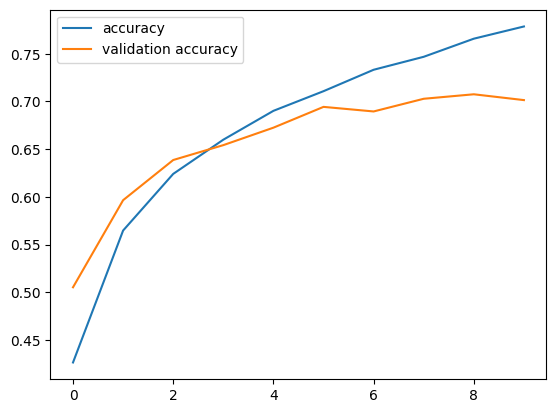

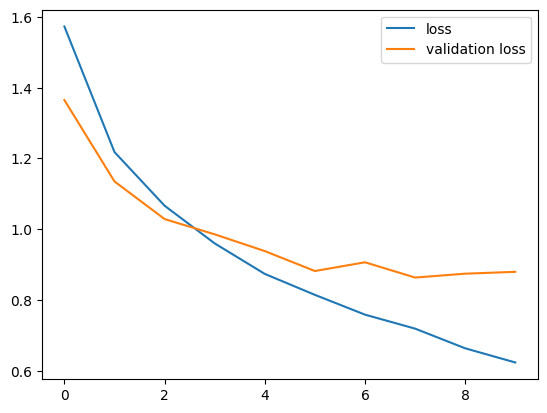

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "validation accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "validation loss"])
plt.show()

That was all from me, hope that it was clear and that you liked it, feel free to experiment a bit, next time we will start from here and use the custom training loop that we saw earlier to train a RL agent

Have funnnnnnnnn


![](https://media.tenor.com/lfDHEnYIUk4AAAAC/this-is-where-the-fun-begins-star-wars.gif)

## (Fun) Exercises

For the braves, I leave here some exercises (they should be pretty simple) to explore a bit and test your knowledge.

I'll give you the main structure of the code and you can just complete it, however, to achieve the same results, there are hundreds of ways, so if you find my scaffolding too cumbersome, or you think there is a better way (let alone possible errors), feel free to experiment... ad if you have questions, feel free to write me at [alberto.sinigaglia@phd.unipd.it](mailto:alberto.sinigaglia@phd.unipd.it)

### Batch Normalization

[Batch Normalization](https://arxiv.org/abs/1502.03167) is a very famous building block for neural networks, it is fundamental for big models, as it solves (tackles at least) a very famous problem in deep hierarchical models, called _internal covariate shift_... in poor words, when you change the parameters in the initial layers, their change is amplified by the change in the next layers, and when you get to the final layers, you have a completely different representation for the same image, thus the final layer has to be trained from scratch.

What BN do is pretty simple, and it's, as the name suggests, a normalization of each batch (intra network, so it's not just a preprocessing).
Given a batch of data of size $N$, BN applied to the $M$th layer, forward propagates the batch in the previous layers, obtaining the batch tensor $t$, and does the following:
$$
\mu = \frac{\sum_{i=0}^N t_i}{N} \\
\sigma^2 = \frac{\sum_{i=0}^N (t_i - \mu)^2}{N} \\
\hat{t} = \frac{t - \mu}{\sqrt{\sigma} + \epsilon}\\
t_\text{final} = \gamma \hat{t} + \beta
$$
in poor words, it first normalizes the batch, and then rescales and shift the tensor using $\beta, \gamma$, which are trained parameters, so that the network is free to learn where is best to have such distribution.

Let's create a Layer that does exactly that (actually, usually $\mu, \sigma$ are moving average, because you need a good statistic for this to work)

In [ ]:
# we assume to be doing the normalization on the last dimension of the batch, so for images, we normalize per channel
class CustomBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, eps=1e-6, momentum=0.5, **kwargs):
    super().__init__(**kwargs)
    self.beta = None # final shift
    self.alpha = None # final rescale
    self.moving_std = None # moving average of the variance
    self.moving_mean = None # moving average of the mean
    self.eps = eps # epsilon, for stability
    self.momentum = momentum # momentum of the moving average
  def build(self, input_shape):
    # we initialize the parameters as we have seen until now, so there should be nothing new here
    self.alpha = self.add_weight("alpha", shape=(input_shape[-1],))
    self.beta = self.add_weight("beta", shape=(input_shape[-1],))
    self.moving_mean = self.add_weight("moving_mean", initializer=tf.zeros_initializer(),  shape=(input_shape[-1],), trainable=False)
    self.moving_std = self.add_weight("moving_mean", initializer=tf.zeros_initializer(),  shape=(input_shape[-1],), trainable=False)
  def call(self, inputs, training, *args, **kwargs):
    # during training, we want to update the statistics
    if training:
      mean = tf.reduce_mean(inputs, axis=(0,1,2), name="batch_mean")
      std = tf.math.reduce_std(inputs, axis=(0,1,2), name="batch_std")
      self.moving_mean.assign(tf.add(self.moving_mean * self.momentum,  mean * (1 - self.momentum), name="new_moving_mean"))
      self.moving_std.assign(tf.add(self.moving_std * self.momentum, std * (1 - self.momentum), name="new_moving_std"))
    # reshape to allow tensor propagation
    mean = tf.reshape(self.moving_mean, (1, 1, -1))
    std = tf.reshape(self.moving_mean, (1, 1, -1))

    processed_inputs = tf.divide(
      tf.subtract(inputs, mean),
      tf.sqrt(std) + self.eps
    )
    return tf.add(tf.multiply(self.beta, processed_inputs), self.alpha)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(CustomBatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10


2023-11-01 12:48:45.313730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 1.6269 - accuracy: 0.4029

2023-11-01 12:49:01.431898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 20s 13ms/step - loss: 1.6267 - accuracy: 0.4029 - val_loss: 1.3563 - val_accuracy: 0.5118
Epoch 2/10
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2736 - accuracy: 0.5461 - val_loss: 1.2499 - val_accuracy: 0.5572
Epoch 3/10
1250/1250 [==============================] - 14s 11ms/step - loss: 1.1460 - accuracy: 0.5972 - val_loss: 1.3264 - val_accuracy: 0.5982
Epoch 4/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0508 - accuracy: 0.6320 - val_loss: 1.0459 - val_accuracy: 0.6326
Epoch 5/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9753 - accuracy: 0.6569 - val_loss: 1.0201 - val_accuracy: 0.6445
Epoch 6/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9077 - accuracy: 0.6812 - val_loss: 1.1197 - val_accuracy: 0.6113
Epoch 7/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8529 - accuracy: 0.7016 - val_loss: 0.9851 - val_accura

### Residual connection

[Residual networks](https://arxiv.org/abs/1512.03385) are the other big famous super used building block for big networks. They solve an orthogonal problem to the one of BN, which is the vanishing gradient. What was observed before ResNet was that deep networks performed better than shallow networks, up to a certain point, and then performances worsened.

The problem is that given a N layer network, you can easily approximate it with a M layer network (M > N), by setting its first N layers with the same weights as the other network, and then the last M-N with an identity function.

However, layers are initialized so that they approximate the zero-function (weights close to 0), so the network has a hard time learning the identity.

To solve that, they just added a residual connection, which is "you some to your output, your input" (given that they have the same shape, otherwise you can concatenate it in some way):
$$
y_i = F(x_i) + x_i
$$
That's all... the intuition is that $F(x_i)$ is initialized with the 0-function, so if it's useless (like the last M-N layers in the previous example), you can just not learn anything in the last layers, and forward the information.

You can also think this as a "gradient descent" idea, where indeed GD has as update $x_i = x_i + F(x_i)$, where $F$ is just the gradient.


Let's code it!

In [ ]:
class CustomResidualLayer(tf.keras.layers.Layer):
  # ffnn want's to be whatever stays between the input and the residual connection, which can be a single layer, or a whole model, makes no difference
  def __init__(self, ffnn, **kwargs):
    super().__init__(**kwargs)
    self.ffnn = tf.keras.models.Sequential(ffnn)

  def call(self, inputs, *args, **kwargs):
    return self.ffnn(inputs) + inputs

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(
  CustomResidualLayer([
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
  ])
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(
  CustomResidualLayer([
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
  ])
)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10


2023-11-01 13:07:21.821512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.4979 - accuracy: 0.4577

2023-11-01 13:07:39.791303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 23s 16ms/step - loss: 1.4971 - accuracy: 0.4581 - val_loss: 1.1557 - val_accuracy: 0.5902
Epoch 2/10
1250/1250 [==============================] - 17s 13ms/step - loss: 1.0295 - accuracy: 0.6396 - val_loss: 1.0275 - val_accuracy: 0.6502
Epoch 3/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.8276 - accuracy: 0.7110 - val_loss: 0.8834 - val_accuracy: 0.6970
Epoch 4/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.7046 - accuracy: 0.7559 - val_loss: 0.8604 - val_accuracy: 0.7110
Epoch 5/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.6036 - accuracy: 0.7877 - val_loss: 0.8213 - val_accuracy: 0.7264
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5261 - accuracy: 0.8161 - val_loss: 0.8615 - val_accuracy: 0.7223
Epoch 7/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4321 - accuracy: 0.8476 - val_loss: 0.8931 - val_accura

### Dropout

[Dropout](https://arxiv.org/abs/1207.0580) is a very famous regularization method proposed from Hinton, that has a toooon of intuitions behind it... in very few words, it just randomly sets values to 0 with some probability (that you choose)

You can see this as a "regularization" since the network cannot rely always on the same information/neuron to predict, or you can see this as a cheap way of training an ensemble of neural networks.

To do so, we just do the following:
$$
m \sim Be(p) ^ {N} \\
y_i = F(x_i) \cdot m
$$

So it's pretty simple, we just need to create a layer that samples random binary masks form a Bernoulli distribution, and multiply.
At test time, we keep all the neurons on and we rescale the activation by $1-p$ (since you would have only $p$ active neurons, you "overstimulate the neuron if you activate all connections without rescaling the sum)

Let's do it.

![](https://media.tenor.com/JOJ1qSZon7UAAAAC/shia-labeouf-just-do-it.gif)

In [ ]:
class CustomDropoutLayer(tf.keras.layers.Layer):
  def __init__(self, prob):
    super(CustomDropoutLayer, self).__init__()
    self.prob = prob

  def call(self, inputs, training=None):
    if training:
      # Generate a random mask with the same shape as the inputs
      mask = tf.random.uniform(shape=tf.shape(inputs), minval=0, maxval=1) >= self.prob
      # Apply the mask to the inputs during training
      masked_inputs = tf.math.divide_no_nan(inputs, 1.0 - self.prob) * tf.cast(mask, dtype=inputs.dtype)
      return masked_inputs
    return inputs

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(CustomDropoutLayer(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10


2023-11-01 13:23:18.645730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.6892 - accuracy: 0.3789

2023-11-01 13:23:32.279434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 17s 12ms/step - loss: 1.6887 - accuracy: 0.3792 - val_loss: 1.4388 - val_accuracy: 0.4800
Epoch 2/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.3490 - accuracy: 0.5159 - val_loss: 1.2290 - val_accuracy: 0.5672
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.2175 - accuracy: 0.5650 - val_loss: 1.1349 - val_accuracy: 0.6028
Epoch 4/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.1170 - accuracy: 0.6023 - val_loss: 1.0849 - val_accuracy: 0.6194
Epoch 5/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.0470 - accuracy: 0.6323 - val_loss: 1.0467 - val_accuracy: 0.6288
Epoch 6/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9936 - accuracy: 0.6479 - val_loss: 1.0002 - val_accuracy: 0.6500
Epoch 7/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9467 - accuracy: 0.6677 - val_loss: 0.9916 - val_accura